In [2]:
import pickle
import pandas as pd 
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Binarizer
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential, load_model 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preperation

In [4]:
# #Load lemmatizationed data as .pkl
with open("/content/drive/MyDrive/data_lem.pkl", 'rb') as f:
    data_lem = pickle.load(f)

#load original data set
df = pd.read_json("https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json")

In [5]:
data_lem[0]

'car wonder enlighten car see day door sport car look late early call bricklin door small addition bumper separate rest body know tellme model engine specs year production car history info funky looking car mail thank'

In [6]:
df.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [7]:
df.groupby("target").count()

,content,target_names
target,,
0,480,480
1,584,584
2,591,591
3,590,590
4,578,578
5,593,593
6,585,585
7,594,594
8,598,598


In [8]:
df.shape, len(data_lem)

((11314, 3), 11314)

In [9]:
df.content = data_lem

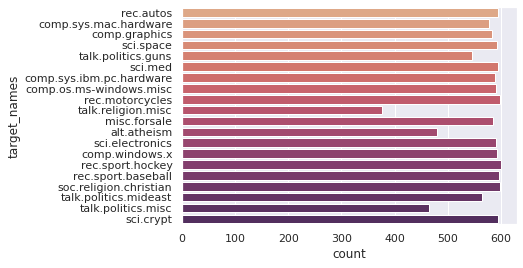

In [10]:
sns.set(font_scale = 1)
sns.countplot(y = "target_names", data = df, palette = "flare") 
#particularly on none-combined categories, the counts almost follow an uniform distribution, this is good for classification

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.content, df.target, test_size=0.30, random_state=1)

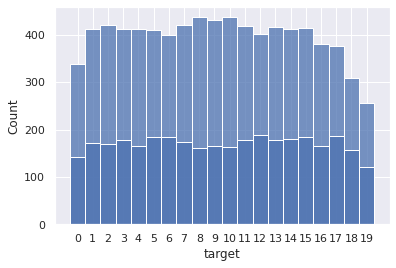

In [12]:
bins = np.arange(21) - 0.5
sns.histplot(y_train, bins = bins)
sns.histplot(y_test, bins = bins)
plt.xticks(np.arange(0,20));
#this actually will probably work out fine, but we can also stratify it, to have some better result (and learn how to do it)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df.content, df.target, test_size=0.30, random_state=1, stratify = df.target)

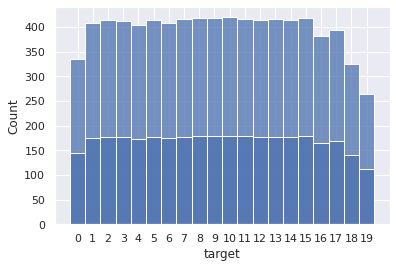

In [14]:
bins = np.arange(21) - 0.5
sns.histplot(y_train, bins = bins)
sns.histplot(y_test, bins = bins)
plt.xticks(np.arange(0,20));
#Better

In [15]:
idf = TfidfVectorizer(max_df = 0.95, min_df = 0.01, smooth_idf = False)
#transform train and test data into vectors
x_train_idf = idf.fit_transform(X_train)
x_test_idf = idf.transform(X_test)

In [16]:
with np.printoptions(threshold=100):
    print(x_train_idf.toarray())
#worked :)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.08346468 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


# Naive Bayes

In [17]:
clf = MultinomialNB()
clf.fit(x_train_idf, y_train)
y_pred = clf.predict(x_test_idf)
accuracy_score(y_test, y_pred), accuracy_score(y_train, clf.predict(x_train_idf))
#the naive bayes can predict 77.5% of the unseen data correctly among 20 possible classifications!

(0.7749631811487482, 0.8525066296249526)

# Keras
can Keras perform better?

In [18]:
x_train_idf = x_train_idf.toarray()
x_test_idf = x_test_idf.toarray()

In [19]:
df2 = pd.DataFrame(x_train_idf)
df2["target"] = y_train
x_train_idf, x_val, y_train, y_val = train_test_split(x_train_idf, y_train, test_size=0.30, random_state=1, stratify = y_train)

In [20]:
x_train_idf.shape

(5543, 1531)

In [21]:
    def get_dumm(num):
        arr = list(np.zeros(20, dtype='int8')) 
        arr[num] = 1 
        return arr

In [22]:
y_tr = np.array([get_dumm(y) for y in y_train])
y_val = np.array([get_dumm(y) for y in y_val])
y_te = np.array([get_dumm(y) for y in y_test])

In [23]:
y_te.shape

(3395, 20)

In [24]:
def get_NN():
    """create NN"""
    #Architecture
    model = Sequential() 
    #Add Input Layer
    model.add(Dense(1531, activation = "relu", input_shape = (1531,)))
    #Add Hidden layers
    #for nodes in hidden layers I followed some of the guides on this post: https://www.researchgate.net/post/How-to-decide-the-number-of-hidden-layers-and-nodes-in-a-hidden-layer 
    #model.add(BatchNormalization())
    model.add(Dropout(0.10))
    model.add(Dense(361, activation = "relu"))
    #model.add(BatchNormalization())
    model.add(Dropout(0.10))
    model.add(Dense(85, activation = "relu"))
    #Add Output layer 
    model.add(Dense(20, activation = "softmax"))
    return model

def plot(fit, NN_preds):
    """return the final confusion matrix, loss plot and accuracy"""
    max_acc = max(fit.history["val_accuracy"])
    max_acc_index = fit.history["val_accuracy"].index(max_acc)
    print(f"best validation accuracy was found at {max_acc} on epoch {max_acc_index}")

    fig, ax = plt.subplots(1, 2, figsize = (30,8))
    #cm = confusion_matrix(y_test, NN_preds, labels=[0,1])
    #cm_matrix = pd.DataFrame(data=cm, columns=["Predicted: 0",'Predicted: 1'], index=['Actual:0','Actual:1'])
    #sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu', ax = ax[0])

    loss = fit.history["loss"]
    test_loss = fit.history["val_loss"]
    epochs = range(1, len(loss)+1)
    sns.lineplot(x = epochs, y = loss, color = "b", label = "Training loss", ax = ax[0])
    sns.lineplot(x = epochs, y = test_loss, color = "g", label = "Test loss", ax = ax[0])

    train_acc = fit.history["accuracy"]
    test_acc = fit.history["val_accuracy"]
    sns.lineplot(x = epochs, y =train_acc, color = "b", label = "Training accuracy", ax = ax[1])
    sns.lineplot(x = epochs, y = test_acc, color = "g", label = "Testing accuracy", ax = ax[1])
    ax[1].axhline(max_acc, color = "r", label = f"Maximum Testing Accuracy = {round(max_acc,3)}")
    plt.legend()

In [208]:
#Compiling
model = get_NN()
#opt = tf.keras.optimizers.SGD(lr = 0.0025)
model.compile(loss = "categorical_crossentropy", optimizer = "SGD", metrics = ["accuracy"])

early_stop = EarlyStopping(patience = 50, monitor = "val_accuracy")
checkpoints =  ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
fit = model.fit(x_train_idf, y_tr, validation_data = (x_val, y_val), epochs = 500, verbose = 1, batch_size = 128, callbacks = [early_stop, checkpoints])

Epoch 1/500
43/44 [============================>.] - ETA: 0s - loss: 2.9971 - accuracy: 0.0469
Epoch 1: val_accuracy improved from -inf to 0.05051, saving model to best_model.h5
44/44 [==============================] - 3s 58ms/step - loss: 2.9971 - accuracy: 0.0465 - val_loss: 2.9955 - val_accuracy: 0.0505
Epoch 2/500
43/44 [============================>.] - ETA: 0s - loss: 2.9954 - accuracy: 0.0520
Epoch 2: val_accuracy improved from 0.05051 to 0.05640, saving model to best_model.h5
44/44 [==============================] - 2s 55ms/step - loss: 2.9955 - accuracy: 0.0518 - val_loss: 2.9947 - val_accuracy: 0.0564
Epoch 3/500
43/44 [============================>.] - ETA: 0s - loss: 2.9952 - accuracy: 0.0558
Epoch 3: val_accuracy improved from 0.05640 to 0.06103, saving model to best_model.h5
44/44 [==============================] - 2s 55ms/step - loss: 2.9952 - accuracy: 0.0557 - val_loss: 2.9940 - val_accuracy: 0.0610
Epoch 4/500
43/44 [============================>.] - ETA: 0s - loss: 2

best validation accuracy was found at 0.7723063826560974 on epoch 368


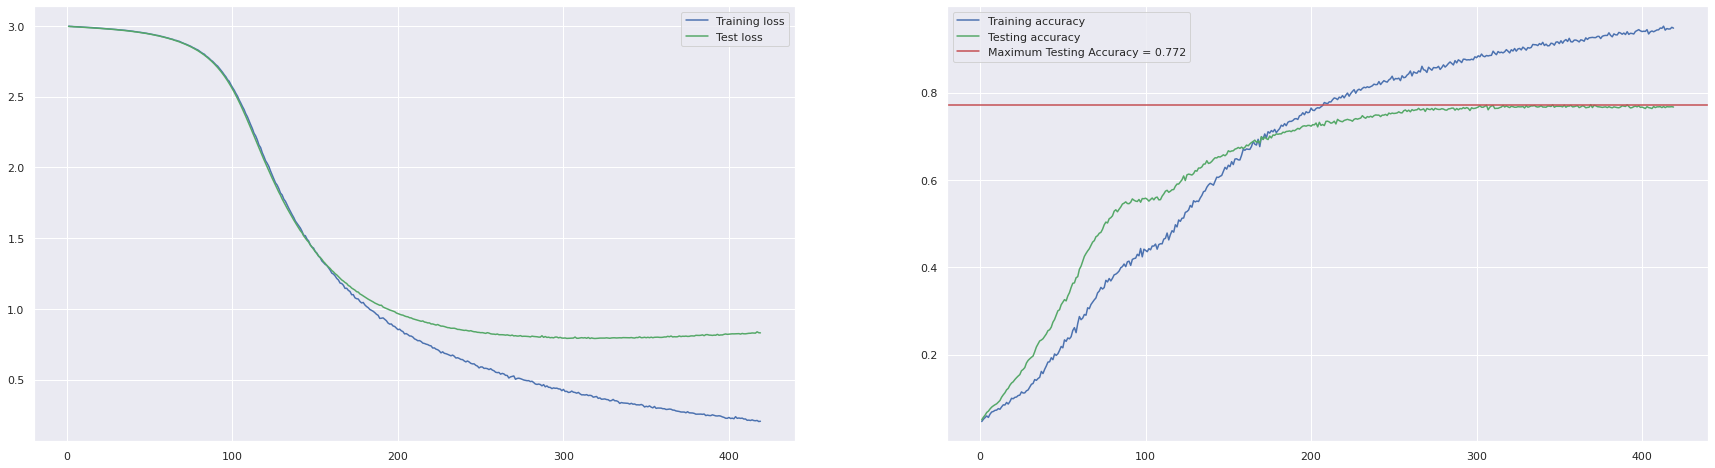

In [209]:
preds = model.predict(x_test_idf)
plot(fit, preds)

## Try 2
Since the first model was learning slow in the start, I put more Hidden Neurons; doubled the learning rate; reduced batch size and increased Dropout to penalize the overfitting

This model yields 1% lower accuracy than the Naive Bayes

In [211]:
def get_NN():
    """create NN"""
    #Architecture
    model = Sequential() 
    #Add Input Layer
    model.add(Dense(1531, activation = "relu", input_shape = (1531,)))
    #Add Hidden layers
    #for nodes in hidden layers I followed some of the guides on this post: https://www.researchgate.net/post/How-to-decide-the-number-of-hidden-layers-and-nodes-in-a-hidden-layer 
    model.add(Dropout(0.20))
    model.add(Dense(450, activation = "relu"))
    model.add(Dropout(0.20))
    model.add(Dense(125, activation = "relu"))
    #Add Output layer 
    model.add(Dense(20, activation = "softmax"))
    return model

In [212]:
#Compiling
model = get_NN()
opt = tf.keras.optimizers.SGD(learning_rate = 0.02)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])

early_stop = EarlyStopping(patience = 50, monitor = "val_accuracy")
checkpoints =  ModelCheckpoint('best_model2.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
fit = model.fit(x_train_idf, y_tr, validation_data = (x_val, y_val), epochs = 500, verbose = 1, batch_size = 64, callbacks = [early_stop, checkpoints])

Epoch 1/500
87/87 [==============================] - ETA: 0s - loss: 2.9947 - accuracy: 0.0556
Epoch 1: val_accuracy improved from -inf to 0.05766, saving model to best_model2.h5
87/87 [==============================] - 5s 54ms/step - loss: 2.9947 - accuracy: 0.0556 - val_loss: 2.9922 - val_accuracy: 0.0577
Epoch 2/500
87/87 [==============================] - ETA: 0s - loss: 2.9910 - accuracy: 0.0635
Epoch 2: val_accuracy improved from 0.05766 to 0.06692, saving model to best_model2.h5
87/87 [==============================] - 6s 66ms/step - loss: 2.9910 - accuracy: 0.0635 - val_loss: 2.9890 - val_accuracy: 0.0669
Epoch 3/500
87/87 [==============================] - ETA: 0s - loss: 2.9883 - accuracy: 0.0658
Epoch 3: val_accuracy improved from 0.06692 to 0.06818, saving model to best_model2.h5
87/87 [==============================] - 3s 39ms/step - loss: 2.9883 - accuracy: 0.0658 - val_loss: 2.9856 - val_accuracy: 0.0682
Epoch 4/500
87/87 [==============================] - ETA: 0s - loss

best validation accuracy was found at 0.7676767706871033 on epoch 141


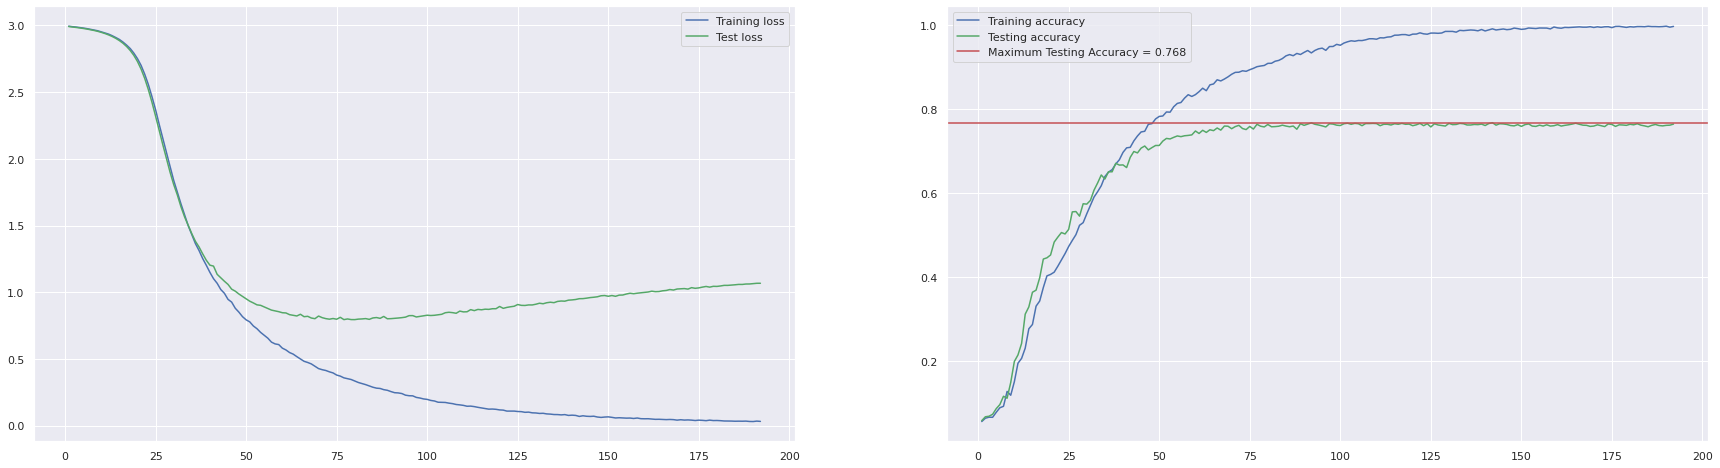

In [213]:
preds = model.predict(x_test_idf)
plot(fit, preds)

## Try 3
further increased dropout and added more hidden neurons

In [214]:
def get_NN():
    """create NN"""
    #Architecture
    model = Sequential() 
    #Add Input Layer
    model.add(Dense(1531, activation = "relu", input_shape = (1531,)))
    #Add Hidden layers
    #for nodes in hidden layers I followed some of the guides on this post: https://www.researchgate.net/post/How-to-decide-the-number-of-hidden-layers-and-nodes-in-a-hidden-layer 
    model.add(Dropout(0.30))
    model.add(Dense(500, activation = "relu"))
    model.add(Dropout(0.30))
    model.add(Dense(150, activation = "relu"))
    #Add Output layer 
    model.add(Dense(20, activation = "softmax"))
    return model

In [222]:
#Compiling
model = get_NN()
opt = tf.keras.optimizers.SGD(learning_rate = 0.02)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])

early_stop = EarlyStopping(patience = 20, monitor = "val_accuracy")
checkpoints =  ModelCheckpoint('best_model3.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
fit = model.fit(x_train_idf, y_tr, validation_data = (x_val, y_val), epochs = 500, verbose = 1, batch_size = 64, callbacks = [early_stop, checkpoints])

Epoch 1/500
87/87 [==============================] - ETA: 0s - loss: 2.9951 - accuracy: 0.0491
Epoch 1: val_accuracy improved from -inf to 0.06019, saving model to best_model3.h5
87/87 [==============================] - 7s 71ms/step - loss: 2.9951 - accuracy: 0.0491 - val_loss: 2.9932 - val_accuracy: 0.0602
Epoch 2/500
87/87 [==============================] - ETA: 0s - loss: 2.9924 - accuracy: 0.0594
Epoch 2: val_accuracy improved from 0.06019 to 0.08291, saving model to best_model3.h5
87/87 [==============================] - 6s 71ms/step - loss: 2.9924 - accuracy: 0.0594 - val_loss: 2.9905 - val_accuracy: 0.0829
Epoch 3/500
86/87 [============================>.] - ETA: 0s - loss: 2.9894 - accuracy: 0.0750
Epoch 3: val_accuracy improved from 0.08291 to 0.09638, saving model to best_model3.h5
87/87 [==============================] - 5s 61ms/step - loss: 2.9894 - accuracy: 0.0758 - val_loss: 2.9877 - val_accuracy: 0.0964
Epoch 4/500
87/87 [==============================] - ETA: 0s - loss

best validation accuracy was found at 0.7756733894348145 on epoch 91


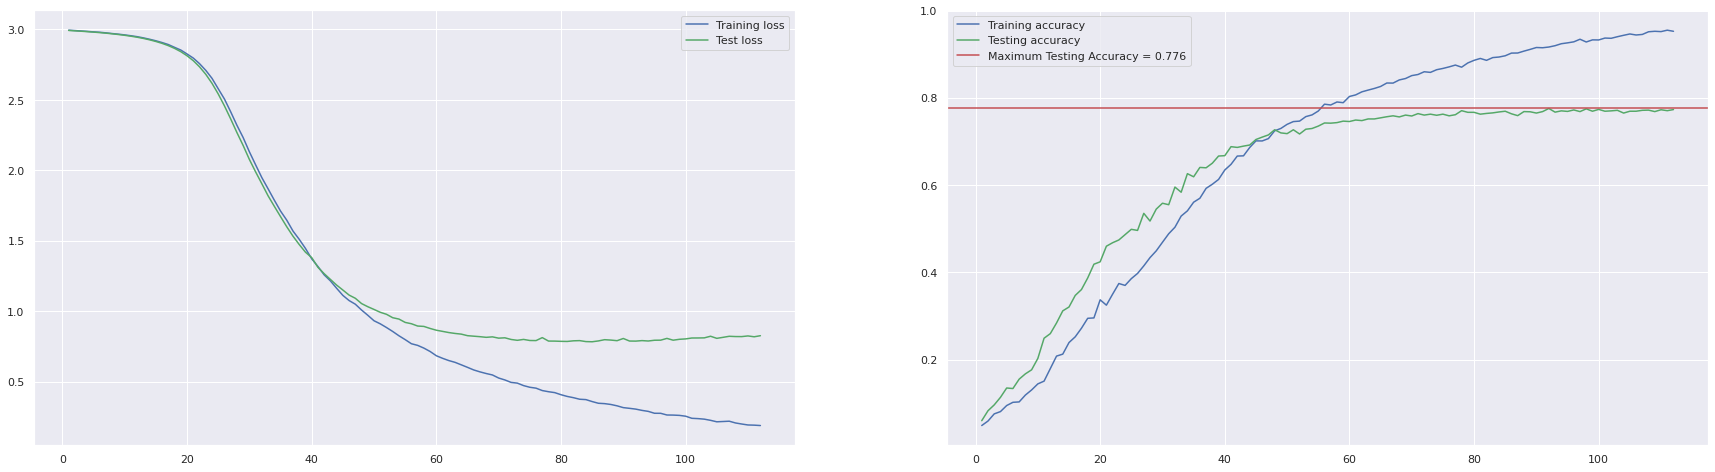

In [223]:
preds = model.predict(x_test_idf)
plot(fit, preds)

## Try 4 
Reduce Neurons again, maintain dropout
Try different optimizer (Adam)

In [70]:
def get_NN():
    """create NN"""
    #Architecture
    model = Sequential() 
    #Add Input Layer
    model.add(Dense(600, activation = "relu", input_shape = (1531,)))
    #Add Hidden layers
    #for nodes in hidden layers I followed some of the guides on this post: https://www.researchgate.net/post/How-to-decide-the-number-of-hidden-layers-and-nodes-in-a-hidden-layer 
    model.add(Dropout(0.30))
    model.add(Dense(450, activation = "relu"))
    model.add(Dropout(0.30))
    model.add(Dense(125, activation = "relu"))
    #Add Output layer 
    model.add(Dense(20, activation = "softmax"))
    return model

In [71]:
#Compiling
model = get_NN()
#opt = tf.keras.optimizers.SGD(learning_rate = 0.02)
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

early_stop = EarlyStopping(patience = 10, monitor = "val_accuracy")
checkpoints =  ModelCheckpoint('best_model4.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
fit = model.fit(x_train_idf, y_tr, validation_data = (x_val, y_val), epochs = 500, verbose = 1, batch_size = 64, callbacks = [early_stop, checkpoints])

Epoch 1/500
87/87 [==============================] - ETA: 0s - loss: 2.2200 - accuracy: 0.3675
Epoch 1: val_accuracy improved from -inf to 0.68855, saving model to best_model4.h5
87/87 [==============================] - 3s 26ms/step - loss: 2.2200 - accuracy: 0.3675 - val_loss: 1.0229 - val_accuracy: 0.6886
Epoch 2/500
85/87 [============================>.] - ETA: 0s - loss: 0.7087 - accuracy: 0.7888
Epoch 2: val_accuracy improved from 0.68855 to 0.75126, saving model to best_model4.h5
87/87 [==============================] - 2s 24ms/step - loss: 0.7054 - accuracy: 0.7902 - val_loss: 0.7944 - val_accuracy: 0.7513
Epoch 3/500
87/87 [==============================] - ETA: 0s - loss: 0.3669 - accuracy: 0.8914
Epoch 3: val_accuracy improved from 0.75126 to 0.76810, saving model to best_model4.h5
87/87 [==============================] - 2s 28ms/step - loss: 0.3669 - accuracy: 0.8914 - val_loss: 0.7523 - val_accuracy: 0.7681
Epoch 4/500
87/87 [==============================] - ETA: 0s - loss

best validation accuracy was found at 0.7752525210380554 on epoch 8


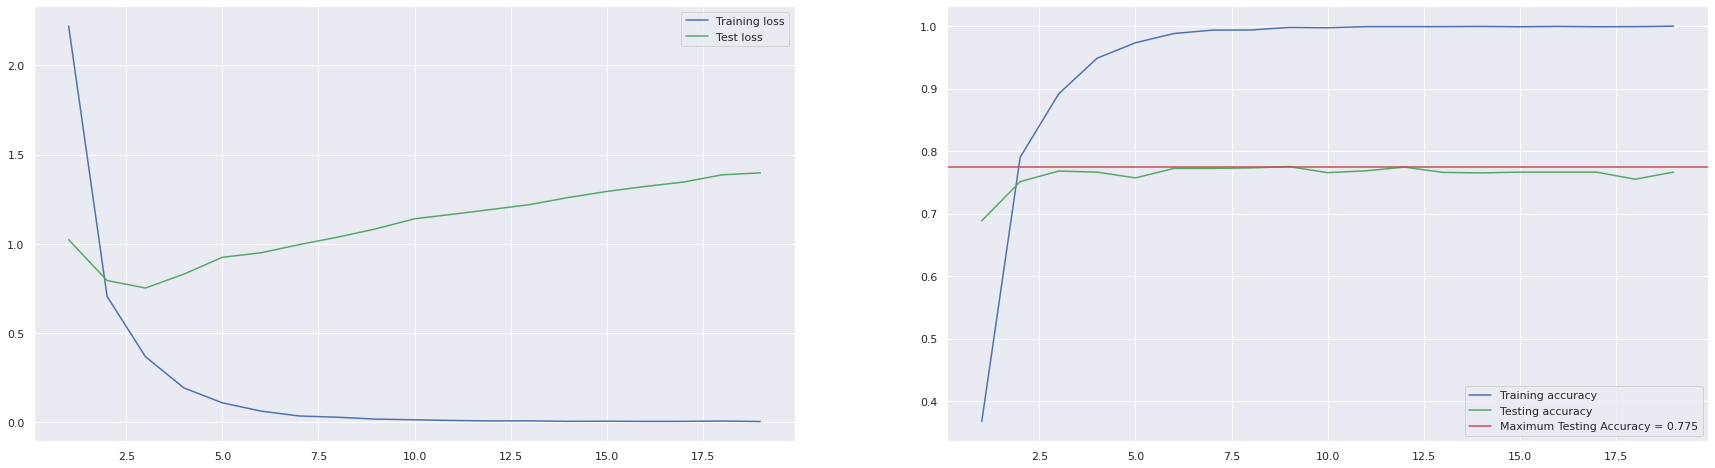

In [72]:
preds = model.predict(x_test_idf)
plot(fit, preds)

## Try 5
Seems like Adam is the better optimizer, but overfits rather quick.
Lets reduce learning rate and neurons

In [62]:
def get_NN():
    """create NN"""
    #Architecture
    model = Sequential() 
    #Add Input Layer
    model.add(Dense(300, activation = "relu", input_shape = (1531,)))
    #Add Hidden layers
    #for nodes in hidden layers I followed some of the guides on this post: https://www.researchgate.net/post/How-to-decide-the-number-of-hidden-layers-and-nodes-in-a-hidden-layer 
    model.add(Dropout(0.30))
    model.add(Dense(150, activation = "relu"))
    #model.add(Dropout(0.30))
    #model.add(Dense(40, activation = "relu"))
    #Add Output layer 
    model.add(Dense(20, activation = "softmax"))
    return model

#Compiling
model = get_NN()
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])

early_stop = EarlyStopping(patience = 10, monitor = "val_accuracy")
checkpoints =  ModelCheckpoint('best_model5.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
fit = model.fit(x_train_idf, y_tr, validation_data = (x_val, y_val), epochs = 500, verbose = 1, batch_size = 128, callbacks = [early_stop, checkpoints])

Epoch 1/500
42/44 [===========================>..] - ETA: 0s - loss: 2.8341 - accuracy: 0.2837
Epoch 1: val_accuracy improved from -inf to 0.58838, saving model to best_model5.h5
44/44 [==============================] - 1s 20ms/step - loss: 2.8209 - accuracy: 0.2926 - val_loss: 2.3467 - val_accuracy: 0.5884
Epoch 2/500
44/44 [==============================] - ETA: 0s - loss: 1.6032 - accuracy: 0.6994
Epoch 2: val_accuracy improved from 0.58838 to 0.72391, saving model to best_model5.h5
44/44 [==============================] - 1s 15ms/step - loss: 1.6032 - accuracy: 0.6994 - val_loss: 1.1008 - val_accuracy: 0.7239
Epoch 3/500
40/44 [==========================>...] - ETA: 0s - loss: 0.8042 - accuracy: 0.8045
Epoch 3: val_accuracy improved from 0.72391 to 0.76305, saving model to best_model5.h5
44/44 [==============================] - 1s 15ms/step - loss: 0.7960 - accuracy: 0.8053 - val_loss: 0.8131 - val_accuracy: 0.7630
Epoch 4/500
40/44 [==========================>...] - ETA: 0s - loss

best validation accuracy was found at 0.7908248901367188 on epoch 10


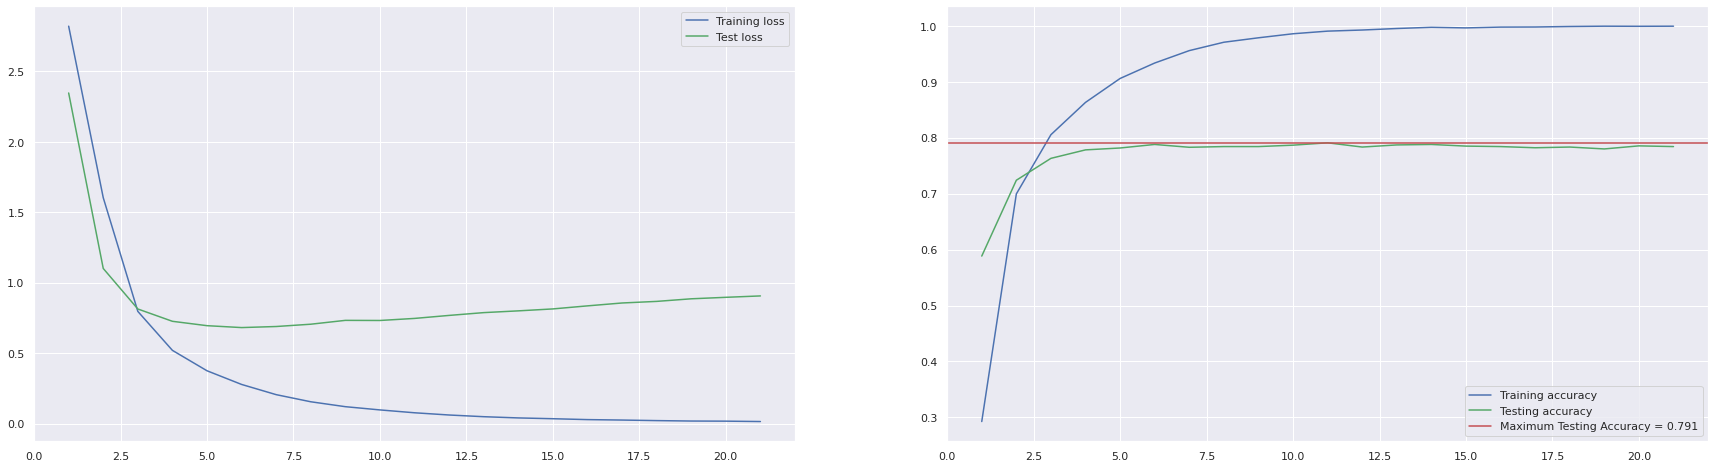

In [63]:
preds = model.predict(x_test_idf)
plot(fit, preds)

## Try 6 
Since reducing neurons also reduced accuracy, maybe increase it instead?
80.2% validation accuracy, 79.1% testing accuracy

In [64]:
def get_NN():
    """create NN"""
    #Architecture
    model = Sequential() 
    #Add Input Layer
    model.add(Dense(800, activation = "relu", input_shape = (1531,)))
    #Add Hidden layers
    #for nodes in hidden layers I followed some of the guides on this post: https://www.researchgate.net/post/How-to-decide-the-number-of-hidden-layers-and-nodes-in-a-hidden-layer 
    model.add(Dropout(0.30))
    model.add(Dense(800, activation = "relu"))
    #model.add(Dropout(0.30))
    #model.add(Dense(200, activation = "relu"))
    #Add Output layer 
    model.add(Dense(20, activation = "softmax"))
    return model

#Compiling
model = get_NN()
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])

early_stop = EarlyStopping(patience = 10, monitor = "val_accuracy")
checkpoints =  ModelCheckpoint('best_model5.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
fit = model.fit(x_train_idf, y_tr, validation_data = (x_val, y_val), epochs = 500, verbose = 1, batch_size = 128, callbacks = [early_stop, checkpoints])

Epoch 1/500
44/44 [==============================] - ETA: 0s - loss: 2.9820 - accuracy: 0.1290
Epoch 1: val_accuracy improved from -inf to 0.26431, saving model to best_model5.h5
44/44 [==============================] - 3s 53ms/step - loss: 2.9820 - accuracy: 0.1290 - val_loss: 2.9614 - val_accuracy: 0.2643
Epoch 2/500
43/44 [============================>.] - ETA: 0s - loss: 2.9290 - accuracy: 0.4055
Epoch 2: val_accuracy improved from 0.26431 to 0.53325, saving model to best_model5.h5
44/44 [==============================] - 2s 44ms/step - loss: 2.9288 - accuracy: 0.4056 - val_loss: 2.8868 - val_accuracy: 0.5332
Epoch 3/500
43/44 [============================>.] - ETA: 0s - loss: 2.8022 - accuracy: 0.5605
Epoch 3: val_accuracy improved from 0.53325 to 0.62037, saving model to best_model5.h5
44/44 [==============================] - 2s 43ms/step - loss: 2.8013 - accuracy: 0.5603 - val_loss: 2.6976 - val_accuracy: 0.6204
Epoch 4/500
43/44 [============================>.] - ETA: 0s - loss

best validation accuracy was found at 0.8021885752677917 on epoch 17


0.7911634756995581

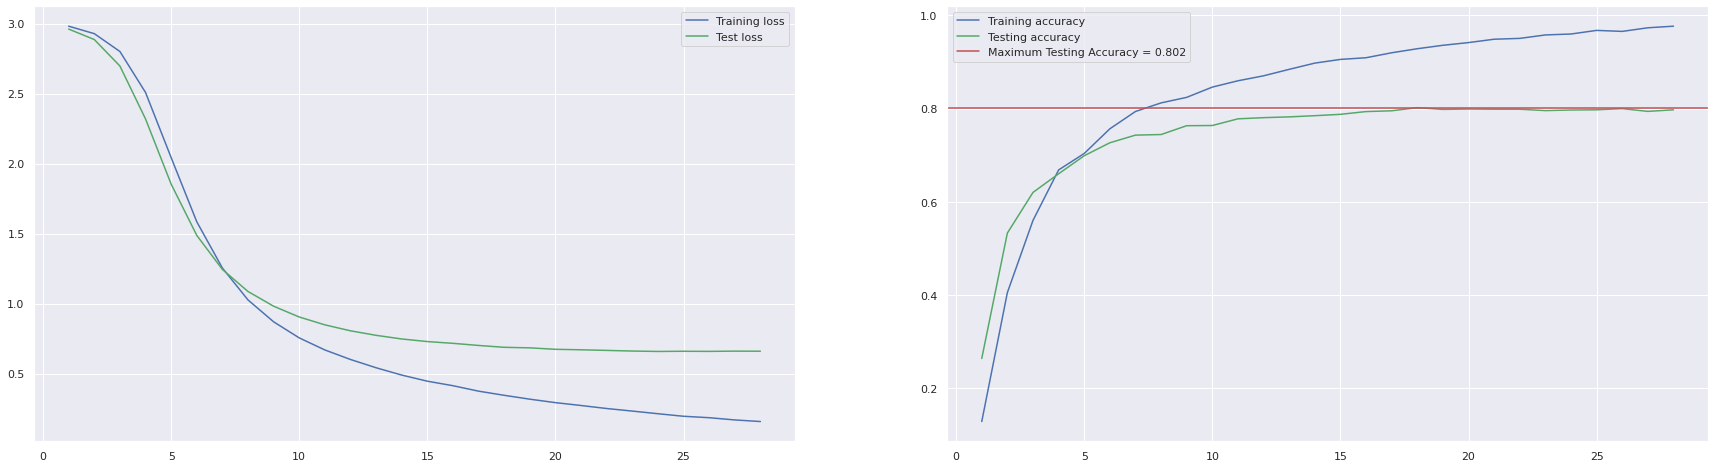

In [65]:
model2 = load_model("/content/best_model5.h5")
preds = model2.predict(x_test_idf)
number_preds = [np.where(i == np.amax(i))[0][0] for i in preds]
plot(fit, preds)
accuracy_score(y_test, number_preds)

## Try 7
very slow adam

79.6% val acc and 78.7% test acc

In [66]:
def get_NN():
    """create NN"""
    #Architecture
    model = Sequential() 
    #Add Input Layer
    model.add(Dense(1000, activation = "relu", input_shape = (1531,)))
    #Add Hidden layers
    #for nodes in hidden layers I followed some of the guides on this post: https://www.researchgate.net/post/How-to-decide-the-number-of-hidden-layers-and-nodes-in-a-hidden-layer 
    model.add(Dropout(0.30))
    model.add(Dense(350, activation = "relu"))
    #Add Output layer 
    model.add(Dense(20, activation = "softmax"))
    return model

#Compiling
model = get_NN()
opt = tf.keras.optimizers.Adam(learning_rate = 0.000005)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])

early_stop = EarlyStopping(patience = 20, monitor = "val_accuracy")
checkpoints =  ModelCheckpoint('best_model7.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
fit = model.fit(x_train_idf, y_tr, validation_data = (x_val, y_val), epochs = 500, verbose = 1, batch_size = 128, callbacks = [early_stop, checkpoints])

Epoch 1/500
44/44 [==============================] - ETA: 0s - loss: 2.9958 - accuracy: 0.0548
Epoch 1: val_accuracy improved from -inf to 0.06776, saving model to best_model7.h5
44/44 [==============================] - 4s 61ms/step - loss: 2.9958 - accuracy: 0.0548 - val_loss: 2.9943 - val_accuracy: 0.0678
Epoch 2/500
43/44 [============================>.] - ETA: 0s - loss: 2.9941 - accuracy: 0.0572
Epoch 2: val_accuracy improved from 0.06776 to 0.07449, saving model to best_model7.h5
44/44 [==============================] - 2s 40ms/step - loss: 2.9942 - accuracy: 0.0572 - val_loss: 2.9928 - val_accuracy: 0.0745
Epoch 3/500
43/44 [============================>.] - ETA: 0s - loss: 2.9921 - accuracy: 0.0630
Epoch 3: val_accuracy improved from 0.07449 to 0.08333, saving model to best_model7.h5
44/44 [==============================] - 2s 42ms/step - loss: 2.9921 - accuracy: 0.0637 - val_loss: 2.9913 - val_accuracy: 0.0833
Epoch 4/500
43/44 [============================>.] - ETA: 0s - loss

best validation accuracy was found at 0.7958754301071167 on epoch 388


0.7873343151693667

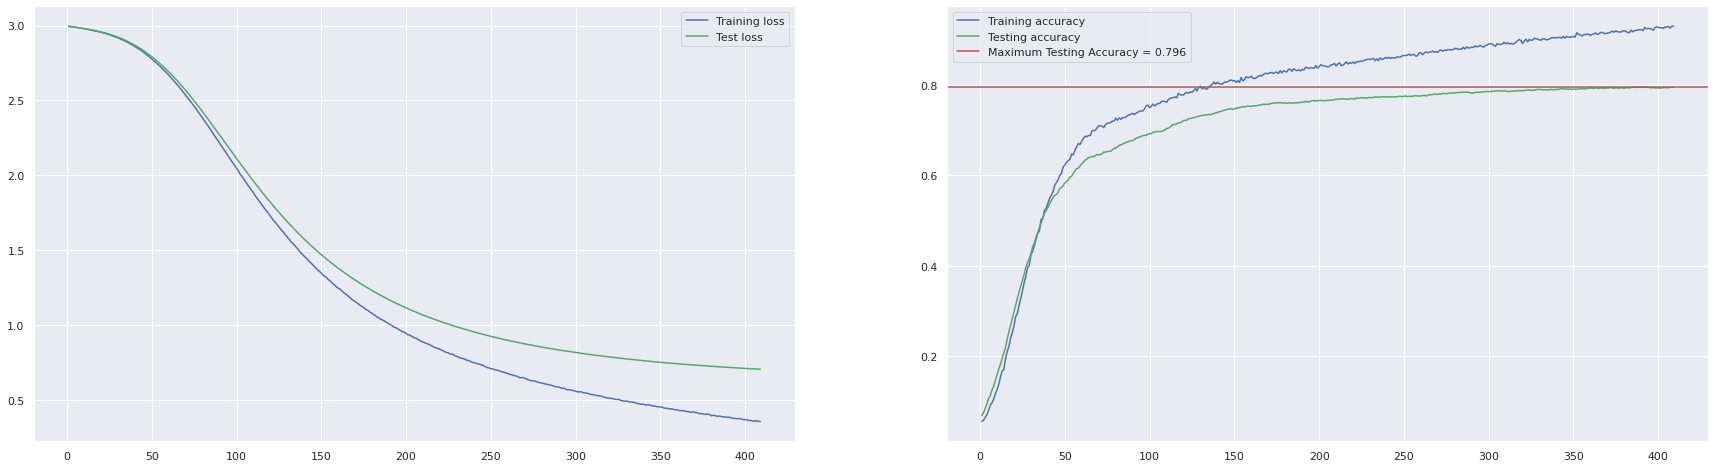

In [67]:
model2 = load_model("/content/best_model7.h5")
preds = model2.predict(x_test_idf)
number_preds = [np.where(i == np.amax(i))[0][0] for i in preds]
plot(fit, preds)
accuracy_score(y_test, number_preds)

##Try 8
Sometimes Batch Normalization can help with the accuracy

This also achieves a good validation accuracy at 80.2%. But given the train test curves, this model looks rather weird - also performing not better on the actual test set

In [68]:
def get_NN():
    """create NN"""
    #Architecture
    model = Sequential() 
    #Add Input Layer
    model.add(Dense(800, activation = "relu", input_shape = (1531,)))
    #Add Hidden layers
    #for nodes in hidden layers I followed some of the guides on this post: https://www.researchgate.net/post/How-to-decide-the-number-of-hidden-layers-and-nodes-in-a-hidden-layer 
    model.add(BatchNormalization())
    model.add(Dropout(0.30))
    model.add(Dense(200, activation = "relu"))
    #Add Output layer 
    model.add(Dense(20, activation = "softmax"))
    return model

#Compiling
model = get_NN()
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)

model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
early_stop = EarlyStopping(patience = 20, monitor = "val_accuracy")
checkpoints =  ModelCheckpoint('best_model10.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
fit = model.fit(x_train_idf, y_tr, validation_data = (x_val, y_val), epochs = 500, verbose = 1, batch_size = 128, callbacks = [early_stop, checkpoints])

Epoch 1/500
42/44 [===========================>..] - ETA: 0s - loss: 2.9191 - accuracy: 0.1334
Epoch 1: val_accuracy improved from -inf to 0.28577, saving model to best_model10.h5
44/44 [==============================] - 2s 36ms/step - loss: 2.9108 - accuracy: 0.1362 - val_loss: 2.9696 - val_accuracy: 0.2858
Epoch 2/500
42/44 [===========================>..] - ETA: 0s - loss: 2.2547 - accuracy: 0.4128
Epoch 2: val_accuracy improved from 0.28577 to 0.48359, saving model to best_model10.h5
44/44 [==============================] - 1s 31ms/step - loss: 2.2476 - accuracy: 0.4158 - val_loss: 2.9229 - val_accuracy: 0.4836
Epoch 3/500
44/44 [==============================] - ETA: 0s - loss: 1.7121 - accuracy: 0.6152
Epoch 3: val_accuracy improved from 0.48359 to 0.58838, saving model to best_model10.h5
44/44 [==============================] - 1s 31ms/step - loss: 1.7121 - accuracy: 0.6152 - val_loss: 2.8473 - val_accuracy: 0.5884
Epoch 4/500
42/44 [===========================>..] - ETA: 0s - l

best validation accuracy was found at 0.8021885752677917 on epoch 71


0.7852724594992636

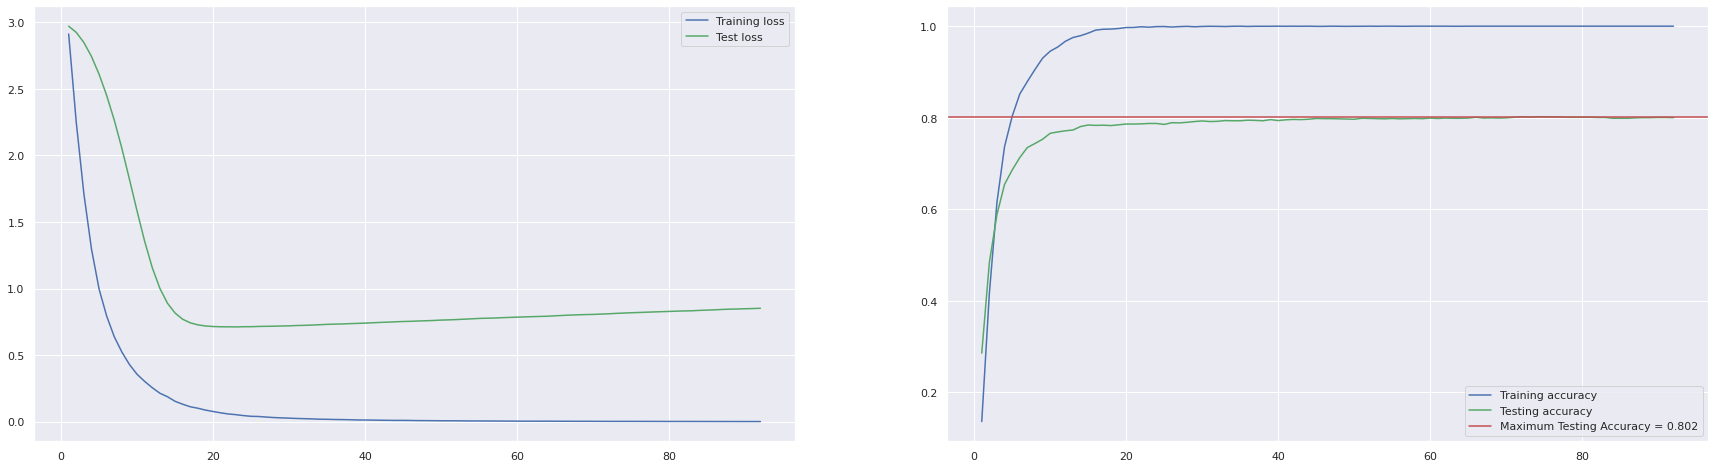

In [69]:
model2 = load_model("/content/best_model10.h5")
preds = model2.predict(x_test_idf)
number_preds = [np.where(i == np.amax(i))[0][0] for i in preds]
plot(fit, preds)
accuracy_score(y_test, number_preds)

# Different Train-Test
Having higher train-set may improve accuracy

In [46]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df.content, df.target, test_size=0.10, random_state=1)
idf = TfidfVectorizer(max_df = 0.95, min_df = 0.01, smooth_idf = False)
#transform train and test data into vectors
x_train_idf2 = idf.fit_transform(X_train2).toarray()
x_test_idf2 = idf.transform(X_test2).toarray()

x_train_idf2, x_val2, y_train2, y_val2 = train_test_split(x_train_idf2, y_train2, test_size=0.30, random_state=1)

y_tr2 = np.array([get_dumm(y) for y in y_train2])
y_val2 = np.array([get_dumm(y) for y in y_val2])
y_te2 = np.array([get_dumm(y) for y in y_test2])

In [61]:
def get_NN():
    """create NN"""
    #Architecture
    model = Sequential() 
    #Add Input Layer
    model.add(Dense(300, activation = "relu", input_shape = (1555,)))
    #Add Hidden layers
    #for nodes in hidden layers I followed some of the guides on this post: https://www.researchgate.net/post/How-to-decide-the-number-of-hidden-layers-and-nodes-in-a-hidden-layer 
    #model.add(Dropout(0.30))
    #model.add(Dense(50, activation = "relu"))
    #model.add(Dropout(0.30))
    model.add(Dense(150, activation = "relu"))
    #Add Output layer 
    model.add(Dense(20, activation = "softmax"))
    return model

#Compiling
model = get_NN()
opt = tf.keras.optimizers.Adam(learning_rate = 0.00005)

model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
early_stop = EarlyStopping(patience = 15, monitor = "val_accuracy")
checkpoints =  ModelCheckpoint('best_model11.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
fit = model.fit(x_train_idf2, y_tr2, validation_data = (x_val2, y_val2), epochs = 500, verbose = 1, batch_size = 128, callbacks = [early_stop, checkpoints])

Epoch 1/500
56/56 [==============================] - ETA: 0s - loss: 2.9914 - accuracy: 0.0803
Epoch 1: val_accuracy improved from -inf to 0.12668, saving model to best_model11.h5
56/56 [==============================] - 3s 36ms/step - loss: 2.9914 - accuracy: 0.0803 - val_loss: 2.9857 - val_accuracy: 0.1267
Epoch 2/500
53/56 [===========================>..] - ETA: 0s - loss: 2.9789 - accuracy: 0.1897
Epoch 2: val_accuracy improved from 0.12668 to 0.24124, saving model to best_model11.h5
56/56 [==============================] - 2s 27ms/step - loss: 2.9786 - accuracy: 0.1898 - val_loss: 2.9735 - val_accuracy: 0.2412
Epoch 3/500
56/56 [==============================] - ETA: 0s - loss: 2.9614 - accuracy: 0.3132
Epoch 3: val_accuracy improved from 0.24124 to 0.33322, saving model to best_model11.h5
56/56 [==============================] - 1s 16ms/step - loss: 2.9614 - accuracy: 0.3132 - val_loss: 2.9552 - val_accuracy: 0.3332
Epoch 4/500
54/56 [===========================>..] - ETA: 0s - l

best validation accuracy was found at 0.7852700352668762 on epoch 284


0.7773851590106007

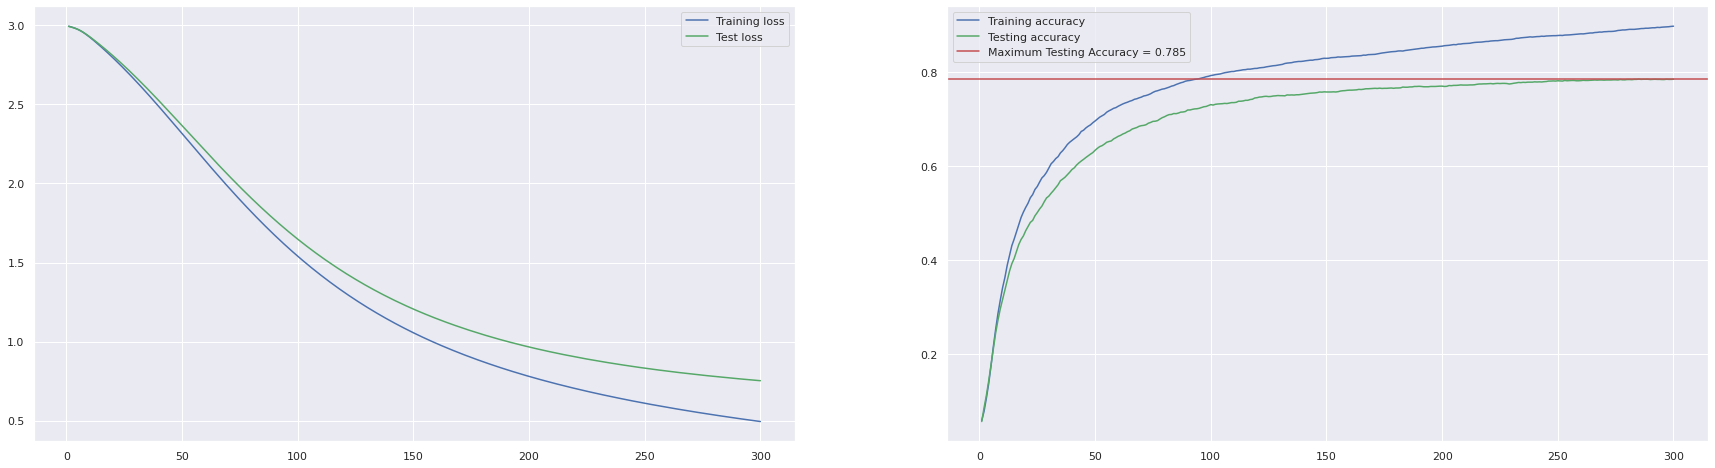

In [60]:
model3 = load_model("/content/best_model11.h5")
preds2 = model3.predict(x_test_idf2)
number_preds2 = [np.where(i == np.amax(i))[0][0] for i in preds2]
plot(fit, preds2)
accuracy_score(y_test2, number_preds2)